## Imports

In [21]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import time
import datetime
from tqdm import tqdm
import json


## Setting

In [70]:


# Basic Settings
def sw_option():
    options = Options()
    options.add_experimental_option("excludeSwitches", ["enable-logging"])
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    return options

driver = webdriver.Chrome(ChromeDriverManager().install(), options=sw_option())
columns = ['Departure_Date', 'Airline', 'Departure_time', 'price']
df = pd.DataFrame(columns = columns)

FROM = 'GMP'
TO = 'CJU'
DATE = datetime.datetime.now().strftime("%Y%m%d")



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\Administrator\.wdm\drivers\chromedriver\win32\98.0.4758.102]


## Crawling

In [19]:
print(datetime.datetime.now().strftime("%Y년 %m월 %d일" + " 크롤링을 시작합니다."))

for i in tqdm(range(1,30)):
    driver.implicitly_wait(5)

    DATE = datetime.datetime.now() + datetime.timedelta(days=i)
    DATE = DATE.strftime("%Y%m%d")        
    URL = f'https://m-flight.naver.com/flights/domestic/{FROM}-{TO}-{DATE}?adult=1&fareType=YC'
    driver.get(url = URL)

    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'domestic_current__nsjAG')))
    time.sleep(1)

    driver.find_element(By.CLASS_NAME, 'domestic_current__nsjAG').click()
    time.sleep(1)
    driver.find_element(By.CLASS_NAME, 'option_option__2qF1U').click()
    time.sleep(1)
    #-----------------------------------------------------------------------------------------------------
    airline = driver.find_elements(By.CLASS_NAME, 'airline')
    departure = driver.find_elements(By.CLASS_NAME, 'time')
    price = driver.find_elements(By.CLASS_NAME, 'domestic_num__2roTW')

    for a,b,c in zip(airline, departure, price):
        df = df.append({'Departure_Date': DATE, 'Airline' : a.text , 'Departure_time' : b.text, 'price' : c.text} , ignore_index=True)

    time.sleep(2)


          

2022년 02월 20일 크롤링을 시작합니다.


 31%|█████████████████████████▊                                                         | 9/29 [01:58<04:23, 13.17s/it]


KeyboardInterrupt: 

## To_Json_File

In [ ]:
def csv_to_json(DATE):
    data = {}
    data[DATE] = {}
    
    df_csv = pd.read_csv(f'{DATE}.csv', encoding="utf-8")
    Departure_Date = list(set(df_csv['Departure_Date']))
    df_dict = df_csv.to_dict(orient = 'records')

    for i in Departure_Date:
        data[DATE][i] = []
        for j in df_dict:
            if j['Departure_Date'] == i:
                data[DATE][i].append(j)        

    with open('json\data.json', 'a', encoding="utf-8") as outfile:
        json.dump(data, outfile, ensure_ascii=False)

## Analysis

## 

In [2]:
!jt -r

Reset css and font defaults in:
C:\Users\Administrator\.jupyter\custom &
C:\Users\Administrator\AppData\Roaming\jupyter\nbextensions


In [70]:
import pandas as pd
import numpy as np

import json
import ujson
import os
import csv

fname = ['20220208.csv','20220211.csv','20220213.csv','20220215.csv','20220216.csv',
         '20220217.csv','20220218.csv', '20220219.csv', '20220220.csv']

columns = ['Departure_Date', 'Airline', 'Departure_time', 'price']
df = []
for f in fname:
    raw_df = pd.read_csv(f'csv_data/{f}', thousands = ',')
    df.append(raw_df)
df = pd.concat(df)
df

,Search_Date,Departure_Date,Airline,Departure_time,price
0,20220208,20220209,진에어,18:15,20900
1,20220208,20220209,제주항공,19:30,19191
2,20220208,20220209,티웨이항공,19:05,22040
3,20220208,20220209,에어부산,20:15,20320
4,20220208,20220209,에어부산,19:05,22340
...,...,...,...,...,...
575,20220220,20220321,아시아나항공,21:45,22176
576,20220220,20220321,티웨이항공,18:15,22400
577,20220220,20220321,티웨이항공,19:25,22176
578,20220220,20220321,티웨이항공,19:20,23500


## 항공사별

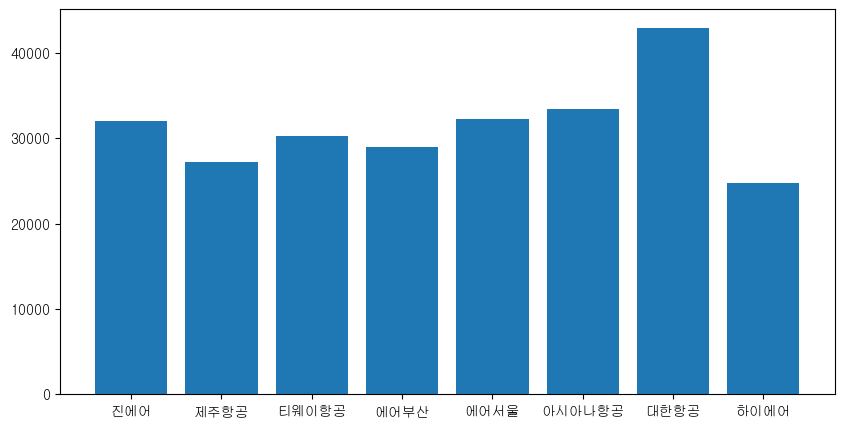

In [31]:
li = df['Airline'].drop_duplicates().to_list()
my_dict = {}
for i in li:
    #print(i, " : ", df[df['Airline'] == i]['price'].mean())
    my_dict[i] = int(df[df['Airline'] == i]['price'].mean())

x = list(my_dict.keys())
y = list(my_dict.values())
plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.show()

In [114]:

df = df[['Search_Date', 'Departure_Date', 'price']]
raw_data = {'Search_Date': [df[df['Search_Date'] == 20220208]]}
data = pd.DataFrame(raw_data)
print(data)


                                         Search_Date
0       Search_Date  Departure_Date  price
0     ...


In [106]:
departure_list = df['Departure_Date'].drop_duplicates().to_list()
search_list = df['Search_Date'].drop_duplicates().to_list()

main_list = []
for i in departure_list:
    li = []
    df2 = df[df['Departure_Date'] == i]
    for j in search_list:
        sub_list = df2[df2['Search_Date'] == j]['price']
        if len(sub_list) == 0:
            pass
        else:
            price = round(sub_list.mean())
            li.append(price)
            print(i,price)
    main_list.append(li)
print(main_list)
        

20220209 22962
20220210 31629
20220211 43366
20220212 34586
20220212 35505
20220213 35647
20220213 37887
20220214 30717
20220214 28446
20220214 32041
20220215 22806
20220215 21125
20220215 21457
20220216 25042
20220216 21598
20220216 23706
20220216 32347
20220217 43243
20220217 41378
20220217 44499
20220217 49192
20220217 46981
20220218 73299
20220218 72063
20220218 75436
20220218 72521
20220218 64282
20220218 57843
20220219 50982
20220219 50843
20220219 52113
20220219 53420
20220219 47166
20220219 41473
20220219 28656
20220220 46473
20220220 50021
20220220 51299
20220220 53921
20220220 50998
20220220 47258
20220220 31167
20220220 27638
20220221 31921
20220221 29715
20220221 30741
20220221 31720
20220221 31527
20220221 32568
20220221 28864
20220221 27750
20220221 28203
20220222 26380
20220222 24390
20220222 25577
20220222 24529
20220222 23264
20220222 22163
20220222 22143
20220222 24238
20220222 23959
20220223 29329
20220223 26895
20220223 28650
20220223 23235
20220223 23041
20220223 2